## VQE and Quantum Graph Neural Networks

In [3]:
import numpy
import math
import random
import numpy as np
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize
import networkx as nx
import cirq
import copy

In order to begin thinking about the quantum graph neural network, we must prepare some training data. We perform VQE in order to find the ground state of a given Ising model Hamiltonian:

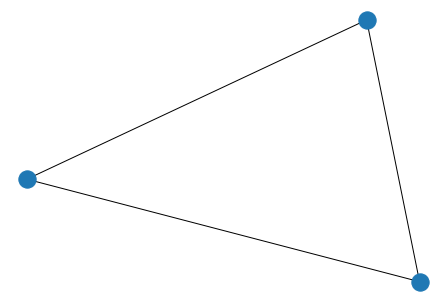

[[1.38, 0.62, 1.24], [1.96, 1.48, 0.78]]


In [4]:
# Initialize the necessary qubits

qubit_number = 3
data_register = [cirq.GridQubit(0, i) for i in range(0, qubit_number)]
network_register = [cirq.GridQubit(1, i) for i in range(0, qubit_number)]

# Creates the graph structure of the quantum system

ising_graph = nx.Graph()
ising_graph.add_nodes_from(range(0, qubit_number))
ising_graph.add_edges_from([(0, 1), (0, 2), (1, 2)])

nx.draw(ising_graph)
plt.show() 

# Creates parameters

matrix_params = [[random.randint(10, 100)/50 for i in range(0, qubit_number)] for j in range(0, 2)]
#matrix_params = [[random.randint(10, 100)/50], [random.randint(10, 100)/50 for i in range(0, qubit_number)]]
print(matrix_params)

In [5]:
# Defines the rz gate:

def rz(control, target, param):
    yield cirq.CX.on(control, target)
    yield cirq.rz(param).on(target)
    yield cirq.CX.on(control, target)

# Method that initializes qubits in even superposition

def even_superposition(qubits):
    
    for i in qubits:
        yield cirq.H.on(i)

# Method that prepares the QAOA ansatz layers

def qaoa_layer(param1, param2, qubits, ising_graph):
    
    # Applies a layer of coupling gates
    for count, i in enumerate(ising_graph.edges):
        yield rz(qubits[i[0]], qubits[i[1]], 2*param1[count])
    
    # Applies the final layer of RX gates on the qubits
    
    for i in range(0, len(qubits)):
        yield cirq.rx(2*param2[i]).on(qubits[i])
    
# Method that prepares the decoupled layers

def decoupled_layer(param1, param2, qubits):
    
    for i in range(0, len(qubits)):
        yield cirq.ZPowGate(exponent=param1[i]).on(qubits[i])
        yield cirq.XPowGate(exponent=param1[i]).on(qubits[i])

# Method that prepares the VQE circuit that will be used to 

def vqe_circuit(parameters, qubits, ising_graph):
    
    yield decoupled_layer(parameters[0], parameters[1], qubits) 
    yield decoupled_layer(parameters[2], parameters[3], qubits)

test_circuit = cirq.Circuit()
test_circuit.append(vqe_circuit([[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], data_register, ising_graph))
print(test_circuit)

(0, 0): ───Z───X───Z───X───

(0, 1): ───Z───X───Z───X───

(0, 2): ───Z───X───Z───X───


In [6]:
# Creates the Hamiltonian that we are attempting to learn

def create_hamiltonian_matrix(n, graph):
    
    # Defines Pauli matrices

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    matrix = np.zeros((2**n, 2**n))
    
    # Creates the interaction component of the Hamiltonian

    for count, i in enumerate(graph.edges):
        m = 1
        for j in range(0, n):
            if (i[0] == j or i[1] == j):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, matrix_params[0][count]*m)
    
    # Creates the "bias" component of the matrix
    
    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, matrix_params[1][i]*m)

    return matrix

print(create_hamiltonian_matrix(qubit_number, ising_graph))

[[ 3.24  0.78  1.48  0.    1.96  0.    0.    0.  ]
 [ 0.78 -0.48  0.    1.48  0.    1.96  0.    0.  ]
 [ 1.48  0.   -2.    0.78  0.    0.    1.96  0.  ]
 [ 0.    1.48  0.78 -0.76  0.    0.    0.    1.96]
 [ 1.96  0.    0.    0.   -0.76  0.78  1.48  0.  ]
 [ 0.    1.96  0.    0.    0.78 -2.    0.    1.48]
 [ 0.    0.    1.96  0.    1.48  0.   -0.48  0.78]
 [ 0.    0.    0.    1.96  0.    1.48  0.78  3.24]]


-4.733192029887759


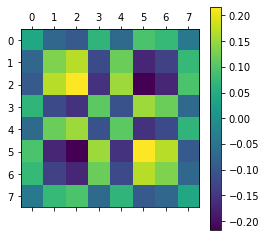

In [7]:
def create_density_matrix(arr):
    
    array = np.array(arr)
    plt.matshow(array)
    plt.colorbar()
    plt.show()

# Finds the eigenvector corresponding to the lowest energy state
    
val, vec = np.linalg.eig(create_hamiltonian_matrix(qubit_number, ising_graph))
m = []

min_ind = list(val).index(min(val))
print(val[min_ind])
for i in range(0, 2**qubit_number):
    m.append(vec[i][min_ind])

create_density_matrix(np.real(np.outer(m, np.conj(m))))

Cost at Step 0= -1.0266294654391461
Cost at Step 50= -4.191408797738016
Cost at Step 100= -4.217535459998638
Cost at Step 150= -4.219076692708244
Cost at Step 200= -4.219371384088474
Cost at Step 250= -4.219520688968403
Cost at Step 300= -4.21963465572165
Cost at Step 350= -4.219713056115008
Cost at Step 400= -4.219763709239612
Cost at Step 450= -4.219794956411263
Cost at Step 500= -4.219796750949329
Cost at Step 550= -4.219797344659681
     fun: -4.219798420504575
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 600
  status: 1
 success: True
       x: array([2.04629748, 2.95118195, 1.01529642, 1.48248871, 1.99213972,
       0.50317522, 0.95476802, 1.95212695, 0.01580236, 1.87057907,
       1.20766187, 1.39872545])


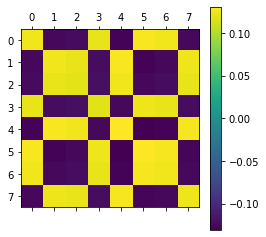

In [8]:
# Creates the VQE method that we will optimize

def create_circuit(parameters, qubits):
    
    # Prepares the circuit
    
    circuit = cirq.Circuit()
    circuit.append(even_superposition(qubits))
    circuit.append(vqe_circuit(parameters, qubits, ising_graph))
    
    # Creates the simulation
    
    simulator = cirq.Simulator()
    results = simulator.simulate(circuit)
    state_vector = results.final_state
    
    return state_vector

# Creates the cost function

iterations = 0

def cost_function(parameters, qubits):
    
    global iterations
    
    hamiltonian = create_hamiltonian_matrix(qubit_number, ising_graph)
    vector = create_circuit(parameters, qubits)
    
    first = np.matmul(hamiltonian, vector)
    cost = np.inner(np.conj(vector), first)
    
    if (iterations%50 == 0):
        print("Cost at Step "+str(iterations)+"= "+str(np.real(cost)))
    
    iterations += 1
    
    return np.real(cost)

# Creates the optimizer for our variational circuit

qubit_register = network_register

def optimizer_cost(params):
    
    parameters = [
        params[0:3], 
        params[3:6],
        params[6:9],
        params[9:12]
    ]
    
    return cost_function(parameters, qubit_register)

# Creates the optimizer

init = [random.randint(0, 20)/10 for i in range(0, 12)]
out = minimize(optimizer_cost, x0=init, method="COBYLA", options={'maxiter':1000, 'tol':1e-10})
g = out['x']
print(out)

# Prepares the optimal state and visualizes it

optimal_params = [
        g[0:3], 
        g[3:6],
        g[6:9],
        g[9:12]
    ]

optimal = create_circuit(optimal_params, qubit_register)
result = np.real(np.outer(optimal, np.conj(optimal)))
create_density_matrix(result)

v = [ 3.21629331,  0.54890376,  2.02976445,  0.7818173 ,  1.3213677 ,
        1.48080682,  1.67054856,  1.44101918,  1.20196752,  0.56441884,
       -0.31570509,  0.15785939,  1.69543663,  0.72541886,  0.02910459,
       -0.52821689]

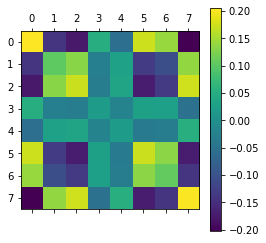

In [104]:
hbar = 1

# Attempts to evolve the prepared ground state forward in time, with the time evolution circuit

def le_state_evolve(depth, time, qubits, ising_graph, params):
    
    yield even_superposition(qubits)
    yield vqe_circuit(params, qubits, ising_graph)
    for i in range(0, depth):
        yield qaoa_layer([i*time/depth for i in matrix_params[0]], [i*time/depth for i in matrix_params[1]], qubits, ising_graph)

# Creates the circuit

def create_time_circuit(depth, time, qubits, ising_graph, params):
    
    circuit = cirq.Circuit()
    circuit.append(le_state_evolve(depth, time, qubits, ising_graph, params))
    
    simulator = cirq.Simulator()
    results = simulator.simulate(circuit)
    state_vector = results.final_state
    
    return state_vector

big_vector = create_time_circuit(60, 30, data_register, ising_graph, optimal_params)
create_density_matrix(np.real(np.outer(big_vector, np.conj(big_vector))))

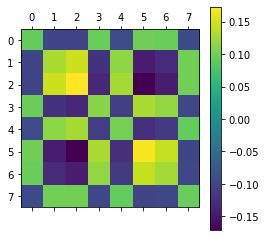

Fidelity: (0.8289933536549383+0j)


In [105]:
# Creates the numrical simulation, to test our time-evolution circuit

def time_evolution_test(time, vec):
    
    new_matrix = scipy.linalg.expm(complex(0,-1)*create_hamiltonian_matrix(qubit_number, ising_graph)*time / hbar)
    return np.matmul(new_matrix, vec)

vec = time_evolution_test(30, optimal)
create_density_matrix(np.real(np.outer(vec, np.conj(vec))))

print("Fidelity: "+str(np.inner(np.conj(vec), big_vector)*np.inner(np.conj(big_vector), vec)))

In [76]:
# Creates the initial "guess" graph of interactions, and assigns parameters to each of the edges

initial_graph = nx.complete_graph(qubit_number)

# Creates the SWAP test between two registers of qubits

def swap_test(control, index1, index2):
    
    yield cirq.H.on(control)
    for i in range(0, len(index1)):
        yield cirq.CSWAP(control, index1[i], index2[i])
    yield cirq.H.on(control)

# Creates the QGRNN ansatz

def qgrnn_ansatz(initial_graph, parameters, opt_params, depth, qubits, time):
    
    yield even_superposition(qubits)
    yield vqe_circuit(opt_params, qubits, ising_graph)
    for i in range(0, depth):
        yield qaoa_layer([i*time/depth for i in parameters[0]], [i*time/depth for i in parameters[1]], qubits, initial_graph)

def find_infidelity_time(depth, time, index1, index2, control, params, opt_params, ising_graph, initial_graph):
    
    circuit = cirq.Circuit()
    circuit.append(qgrnn_ansatz(initial_graph, params, opt_params, depth, index2, time))
    #circuit.append(cirq.measure(control, key="q"))
    
    simulator = cirq.Simulator()
    results = simulator.simulate(circuit)
    
    return results.final_state

#control = cirq.GridQubit(2, 0)

In [98]:
# Now, we define the cost function that is used in the optimization method

time_range = range(1, 100)

def prep_states(time_range, depth, qubits, ising_graph, params):
    
    times = []
    for i in time_range:
        times.append(np.array(create_time_circuit(depth, i, qubits, ising_graph, params)))
    return times

state_range = prep_states(time_range, 60, data_register, ising_graph, optimal_params)

iterations = 0
params_step = 0
best_cost = math.inf

def cost_function(params):
    
    global iterations
    global params_step
    global best_cost
    
    old_params = copy.copy(params)
    params = [params[0:3], params[3:6]]
    
    total_cost = 0
    
    batch = 15
    stoch = [time_range[random.randint(0, 98)] for i in range(0, batch)]
    
    for i in stoch:
        res = np.array(find_infidelity_time(60, i, data_register, network_register, control, params, optimal_params, ising_graph, initial_graph))
        total_cost += 1 - (np.dot(np.conj(state_range[i-1]), res) * np.dot(np.conj(res), state_range[i-1]))
        
    print("Cost at Step "+str(iterations)+": "+str(1 - (total_cost / len(time_range)))+", Parameters: "+str(params))
    
    iterations += 1
    
    if ((total_cost / len(time_range)) < best_cost):
        params_step = old_params
        best_cost = total_cost / len(time_range)
    
    return (total_cost / len(time_range)).real

print(ising_graph.edges)
print(initial_graph.edges)

[(0, 1), (0, 2), (1, 2)]
[(0, 1), (0, 2), (1, 2)]


In [99]:
init = [random.randint(10, 100)/50 for i in range(0, 6)]
#init = [1.96, 1.08, 0.32, 1.04, 1.28, 0.5]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})
g = out['x']
print(out)

Cost at Step 0: (0.9184971086756147+0j), Parameters: [array([1.6 , 0.98, 1.88]), array([0.2 , 2.  , 1.94])]
Cost at Step 1: (0.8934280182413682+0j), Parameters: [array([2.6 , 0.98, 1.88]), array([0.2 , 2.  , 1.94])]
Cost at Step 2: (0.8994478960756702+0j), Parameters: [array([1.6 , 1.98, 1.88]), array([0.2 , 2.  , 1.94])]
Cost at Step 3: (0.896350188747594+0j), Parameters: [array([1.6 , 0.98, 2.88]), array([0.2 , 2.  , 1.94])]
Cost at Step 4: (0.9126066498909936+0j), Parameters: [array([1.6 , 0.98, 1.88]), array([1.2 , 2.  , 1.94])]
Cost at Step 5: (0.9131285945574442+0j), Parameters: [array([1.6 , 0.98, 1.88]), array([0.2 , 3.  , 1.94])]
Cost at Step 6: (0.9109456597855596+0j), Parameters: [array([1.6 , 0.98, 1.88]), array([0.2 , 2.  , 2.94])]
Cost at Step 7: (0.8929462017746632+0j), Parameters: [array([0.97373457, 0.50412062, 1.326735  ]), array([0.05284705, 1.86588605, 1.75135289])]
Cost at Step 8: (0.934959036984829+0j), Parameters: [array([1.28686729, 0.74206031, 1.6033675 ]), arr

[1.32453816 0.67227542 1.57160011 0.1890507  1.95353688 1.90798125]
[[1.38, 0.62, 1.24], [1.96, 1.48, 0.78]]


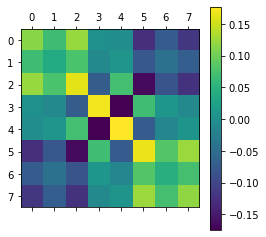

Fidelity: (0.17534651+0j)


In [103]:
# Prepares the optimal state
circuit = cirq.Circuit()
#g = params_step
print(g)
print([[1.38, 0.62, 1.24], [1.96, 1.48, 0.78]])
#g = out['x']
circuit.append(qgrnn_ansatz(initial_graph, [g[0:3], g[3:6]], optimal_params, 60, network_register, 30))

simulator = cirq.Simulator()
results = simulator.simulate(circuit)
state_vector = results.final_state

create_density_matrix(np.real(np.outer(state_vector, np.conj(state_vector))))

print("Fidelity: "+str(np.inner(np.conj(state_vector), big_vector)*np.inner(np.conj(big_vector), state_vector)))